In [1]:
%pylab inline
rcParams["font.size"] = 15

Populating the interactive namespace from numpy and matplotlib


## load data

In [2]:
import joblib
[params, spec_list] = joblib.load("/Users/cham/PycharmProjects/spectroscopy/stellar_parameters/demo_slam/slamplus_test_data.dump")

## Teff-logg distribution

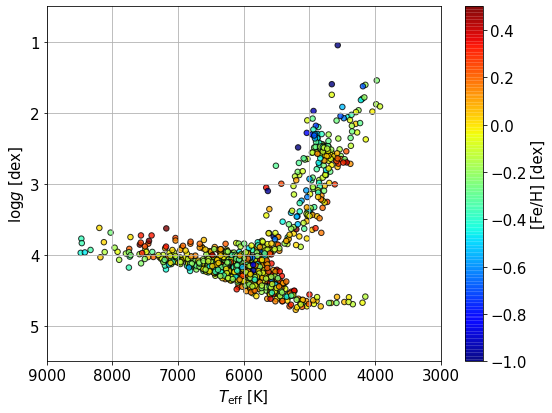

In [3]:
# Teff-logg
from astropy.table import Table
fig = figure(figsize(8, 6))
scatter(params["teff"], params["logg"], s=30, c=params["feh"], marker="o", edgecolors="k", alpha=.8, cmap=cm.jet, vmin=-1, vmax=0.5)
c = colorbar()
c.set_label("[Fe/H] [dex]")
grid(True)
xlim(9000, 3000)
ylim(5.5,0.5)
xlabel("$T_\mathrm{eff}$ [K]")
ylabel("$\log{g}$ [dex]")
fig.tight_layout()

## view spectra

Text(0, 0.5, 'Normalized Flux')

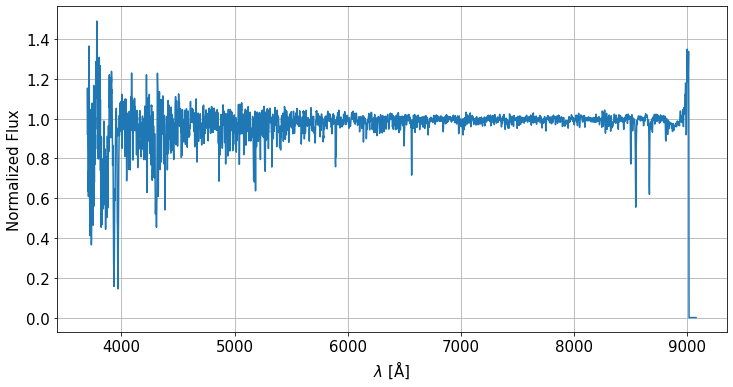

In [4]:
from laspec.mrs import MrsSpec
ms = spec_list[0]
fig = figure(figsize=(12, 6))
ms.plot_norm()
grid(True)
xlabel("$\lambda$ [$\mathrm{\AA}$]")
ylabel("Normalized Flux")

## normalize & interpolate spectra

In [5]:
# define wavelength
wave = np.arange(4000, 5800, 1.)
npix = len(wave)
nobs = len(params)
# interpolate spectra
flux_norm = np.array([np.interp(wave, ms.wave/(1+params["rv"][i]/299792.458), ms.flux_norm) for i,ms in enumerate(spec_list)])
ivar_norm = np.array([np.interp(wave, ms.wave/(1+params["rv"][i]/299792.458), ms.flux_norm_err**-2) for i,ms in enumerate(spec_list)])

## train SLAM+ (~10min, converge to mae=0.0232)

In [ ]:
from laspec.slamplus import SlamPlus
# initialize slam plus (s)

from laspec.slamplus import SlamPlus
# initialize slam plus (s)
s = SlamPlus(flux_norm, np.array(params["teff", "logg", "feh"].to_pandas()), wave=wave)
# initialize NN model
s.initialize(nhidden=(100, 300))
# train the model and generate slam predictor (sp)
sp = s.train(loss="mae", batch_size=50, learning_rate=1e-4, epochs=10000, test_size=0.1,
             factor_reducelronplateau=0.5, patience_reducelronplateau=50, patience_earlystopping=50)

## the learning curve

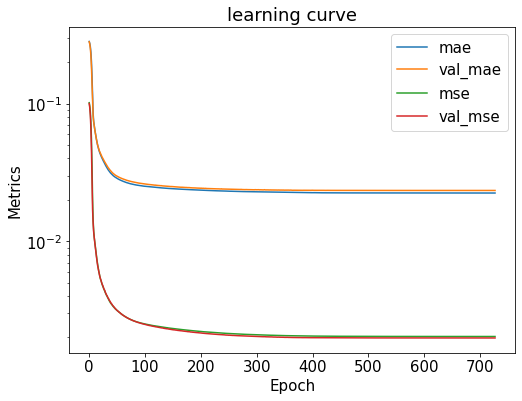

In [7]:
figure()
semilogy(s.history.history["mae"], label="mae")
semilogy(s.history.history["val_mae"], label="val_mae")
semilogy(s.history.history["mse"], label="mse")
semilogy(s.history.history["val_mse"], label="val_mse")
title("learning curve")
xlabel("Epoch")
ylabel("Metrics")
legend()

## fitting performance

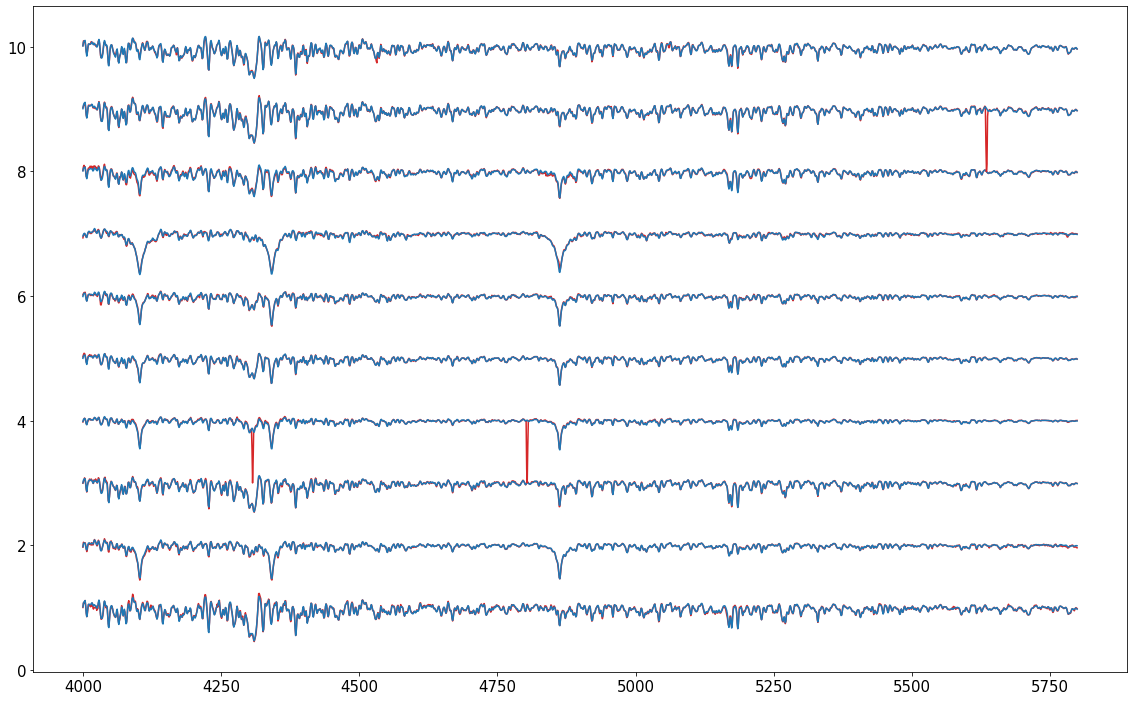

In [8]:
fig = figure(figsize=(16, 10))
for i in range(10):
    plot(sp.wave, s.tr_flux[i]+i, color="tab:red")
    plot(sp.wave, sp.predict_one_spectrum(s.tr_label[i])+i, color="tab:blue")
fig.tight_layout()

## speed

In [9]:
%%timeit
sp.predict_one_spectrum(s.tr_label[0])

2.96 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## predict labels

In [10]:
from astropy.table import Table
xpred,_ = sp.curve_fit_multiple(s.tr_flux, method="trf", n_jobs=8)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  36 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 106 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 176 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 266 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done 356 tasks      | elapsed:    8.5s
[Parallel(n_jobs=8)]: Done 466 tasks      | elapsed:    9.9s
[Parallel(n_jobs=8)]: Done 576 tasks      | elapsed:   11.3s
[Parallel(n_jobs=8)]: Done 706 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done 836 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done 941 tasks      | elapsed:   16.9s
[Parallel(n_jobs=8)]: Done 965 tasks      | elapsed:   17.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:   17.3s finished


## diagnal plot

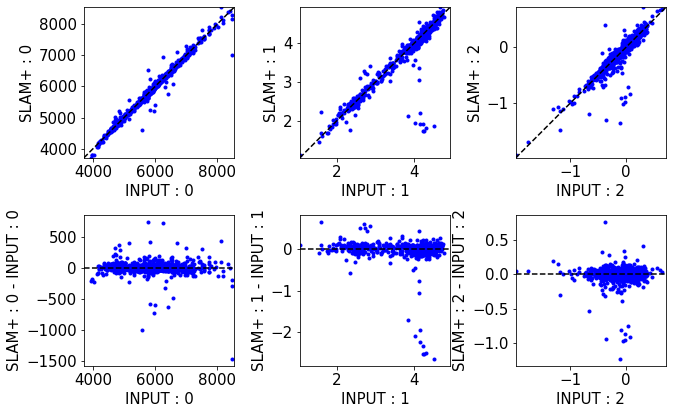

In [11]:
from slam.diagnostic import compare_labels
fig = compare_labels(s.tr_label, xpred, labelname1="INPUT", labelname2="SLAM+",)